In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import re

In [2]:
today = pd.Timestamp.today()

sp500_data = yf.download('^SPX', end=today)
sp500 = sp500_data['Close']
sp500 = pd.DataFrame(sp500)

# Extract year, month, and day from the index and store it in a new column
sp500["Date"] = sp500.index.to_series().dt.strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Porftolio Liquidation Function and Model

def liquidate_portfolio(invested, value, tax_rate, year, years, ticker):
    today = pd.Timestamp.today()
    data = yf.download(ticker, start=str(year)+'-01-01', end=today)
    data = data['Close']
    data = pd.DataFrame(data)
    data["Date"] = data.index.to_series().dt.strftime('%Y-%m-%d')

    # Tax Portfolio on Gains
    asset_value = ((value - invested) * (1-tax_rate)) + invested

    # Function to get the first available date of a given year
    def get_first_date_of_year(data, year):
        first_date = data[data.index.year == year].index.min()
        if pd.isna(first_date):
            raise KeyError(f"No data available for the year {year}")
        return first_date

    dates = []
    values = []
    distributions = []

    # buy shares at specified year
    first_date = get_first_date_of_year(data, year)
    shares = asset_value / data.at[first_date, 'Close']

    print(f"{shares} Shares of {ticker} bought at {data.at[first_date, 'Close']}, total cost: {asset_value}")

    # sell $ amount per year and receive dividend
    for i in range(year, year + years):
        first_date_of_year = get_first_date_of_year(data, i)
        asset_value = shares * data.at[first_date_of_year, 'Close']

        sell_shares = (0.03*asset_value) / data.at[first_date_of_year, 'Close']
        shares -= sell_shares

        # Store the date and value
        dates.append(first_date_of_year)
        values.append(asset_value)
        distributions.append(round((0.03*asset_value), 2))

        print(f"Year {i}: Sold {sell_shares} shares for {round((0.03*asset_value), 2)} for expenses pre tax, remaining shares: {shares} value: {asset_value}")

    # Final asset value
    final_date = data[data.index.year == (year + years - 1)].index.max()
    final_asset_value = shares * data.at[final_date, 'Close']
    print(f"Final asset value after {years} years: {final_asset_value}")

    # Store the final date and value
    dates.append(final_date)
    values.append(final_asset_value)

    return dates, values, distributions



[*********************100%%**********************]  1 of 1 completed

12461.326851101836 Shares of ^SPX bought at 465.44000244140625, total cost: 5800000.0
Year 1994: Sold 373.8398055330551 shares for 174000.0 for expenses pre tax, remaining shares: 12087.487045568781 value: 5800000.0
Year 1995: Sold 362.62461136706344 shares for 166484.58 for expenses pre tax, remaining shares: 11724.862434201717 value: 5549486.0004282845
Year 1996: Sold 351.7458730260515 shares for 218339.21 for expenses pre tax, remaining shares: 11373.116561175666 value: 7277973.629780812
Year 1997: Sold 341.19349683526997 shares for 251463.02 for expenses pre tax, remaining shares: 11031.923064340395 value: 8382100.747817669
Year 1998: Sold 330.9576919302118 shares for 322696.98 for expenses pre tax, remaining shares: 10700.965372410183 value: 10756566.022253806
Year 1999: Sold 321.02896117230546 shares for 394255.66 for expenses pre tax, remaining shares: 10379.936411237877 value: 13141855.312602907
Year 2000: Sold 311.3980923371363 shares for 453152.72 for expenses pre tax, remain

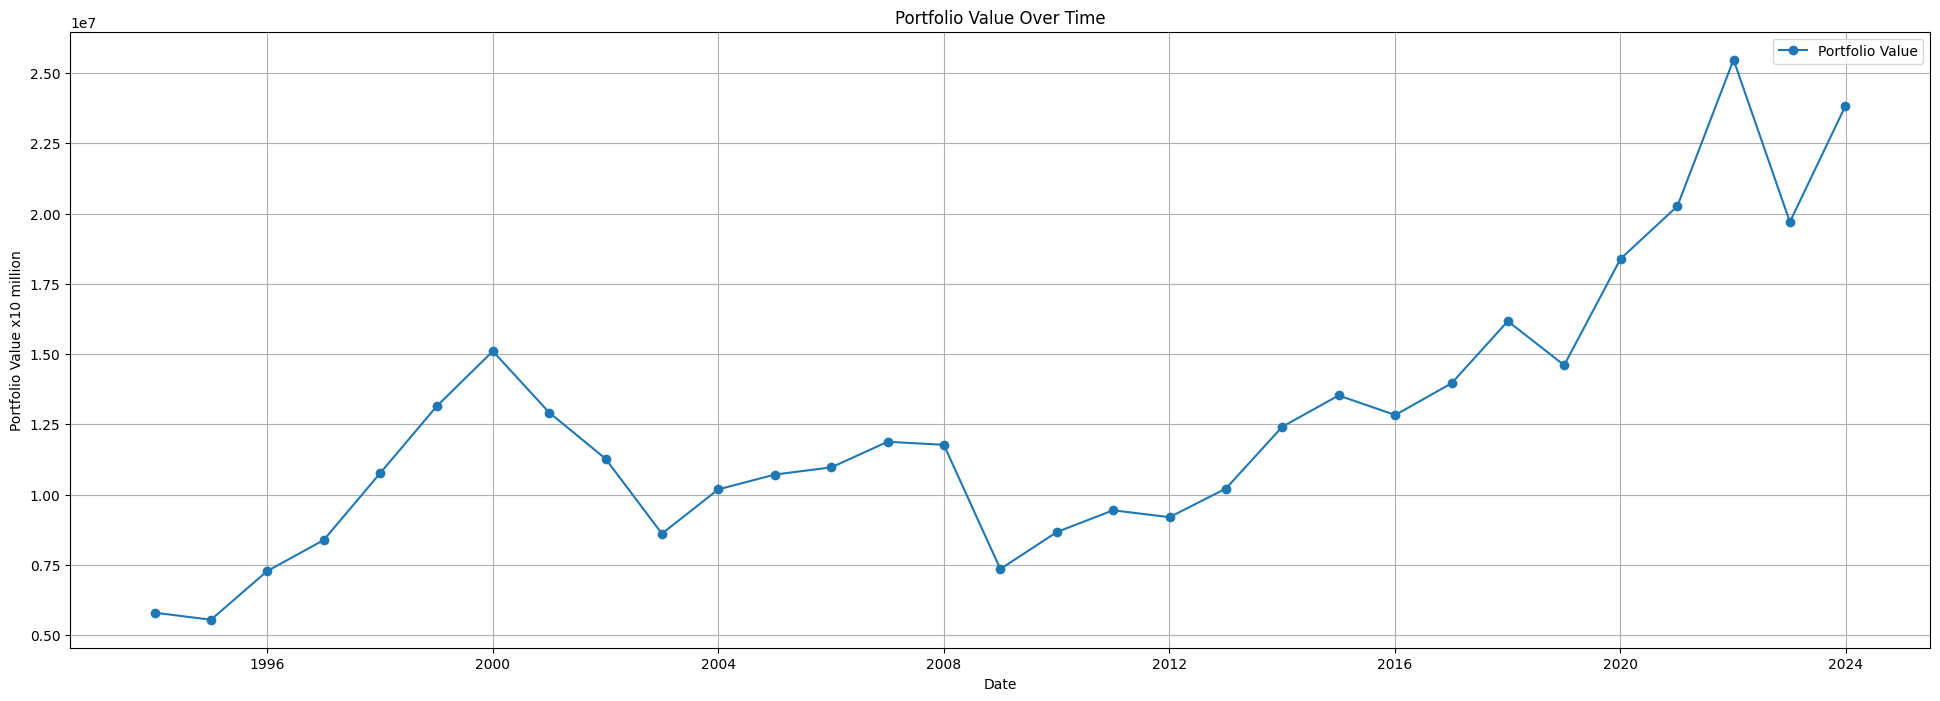

yearly distributions


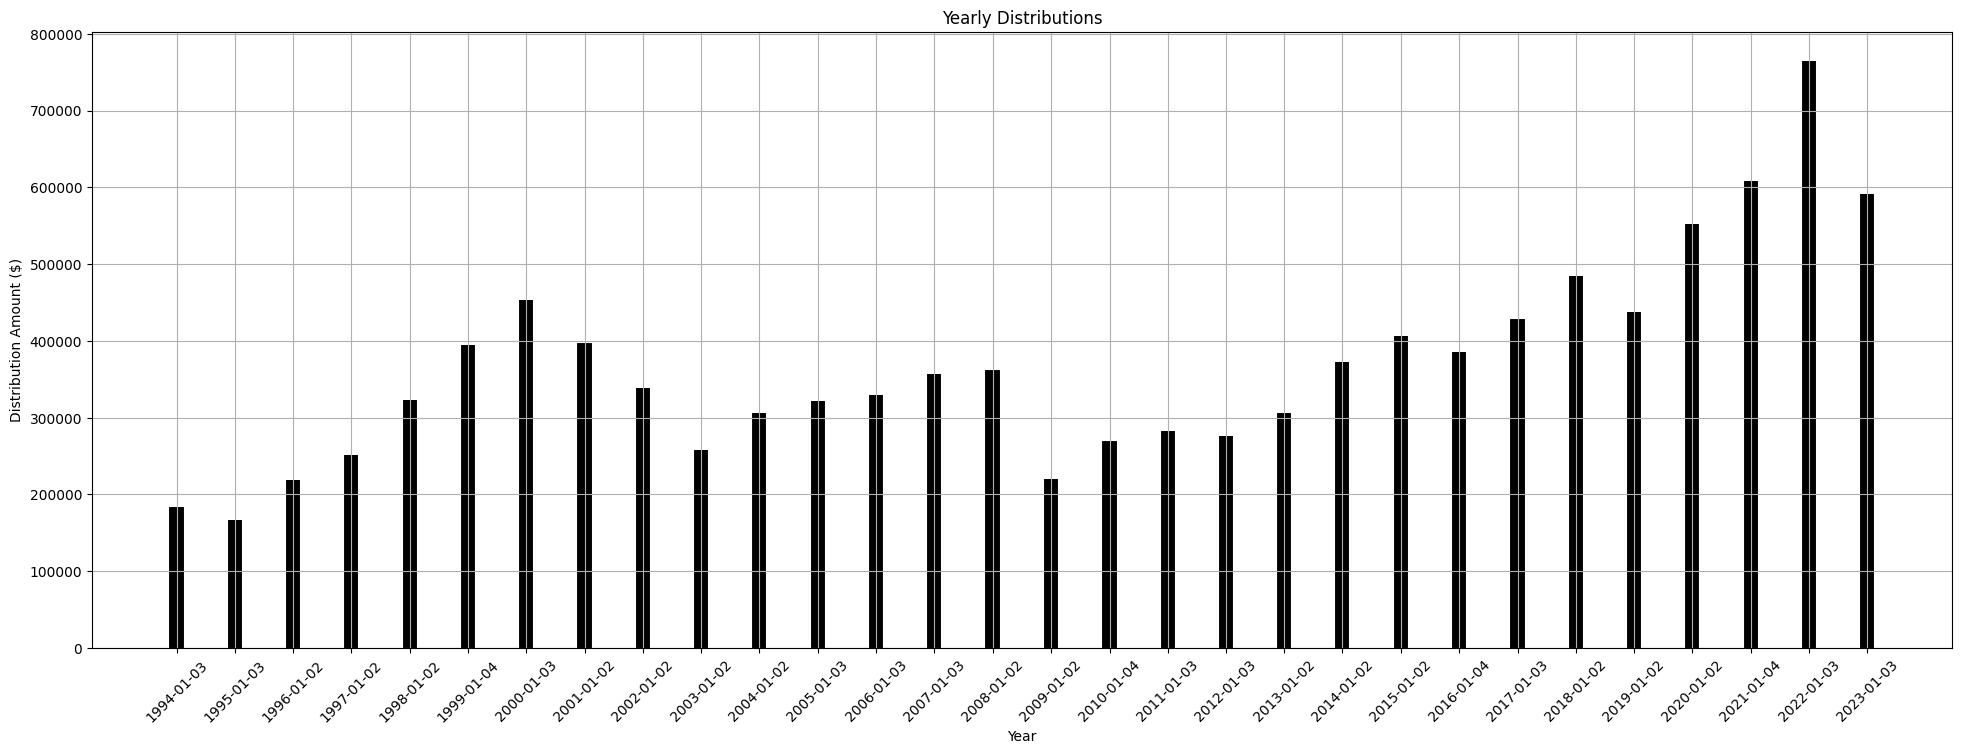

sp500 and sell dates


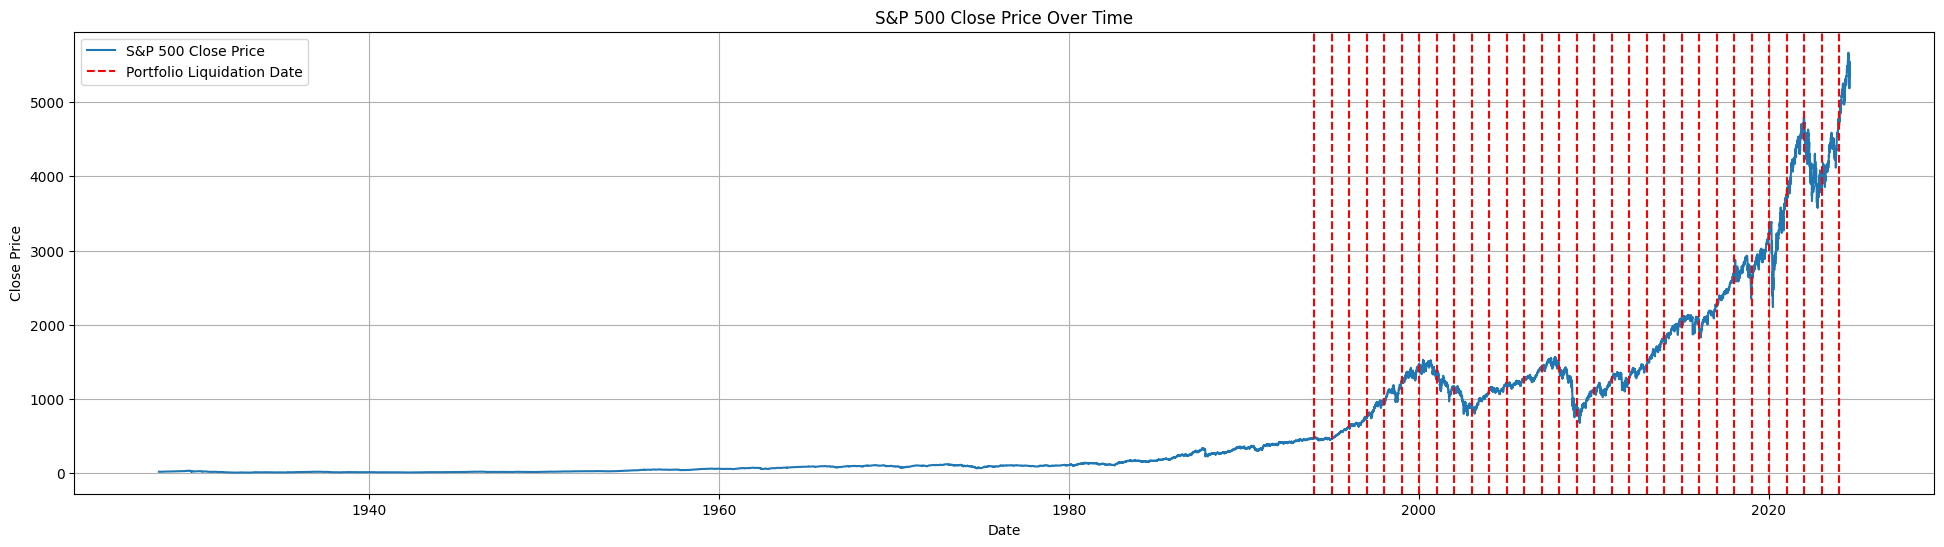

overlayed


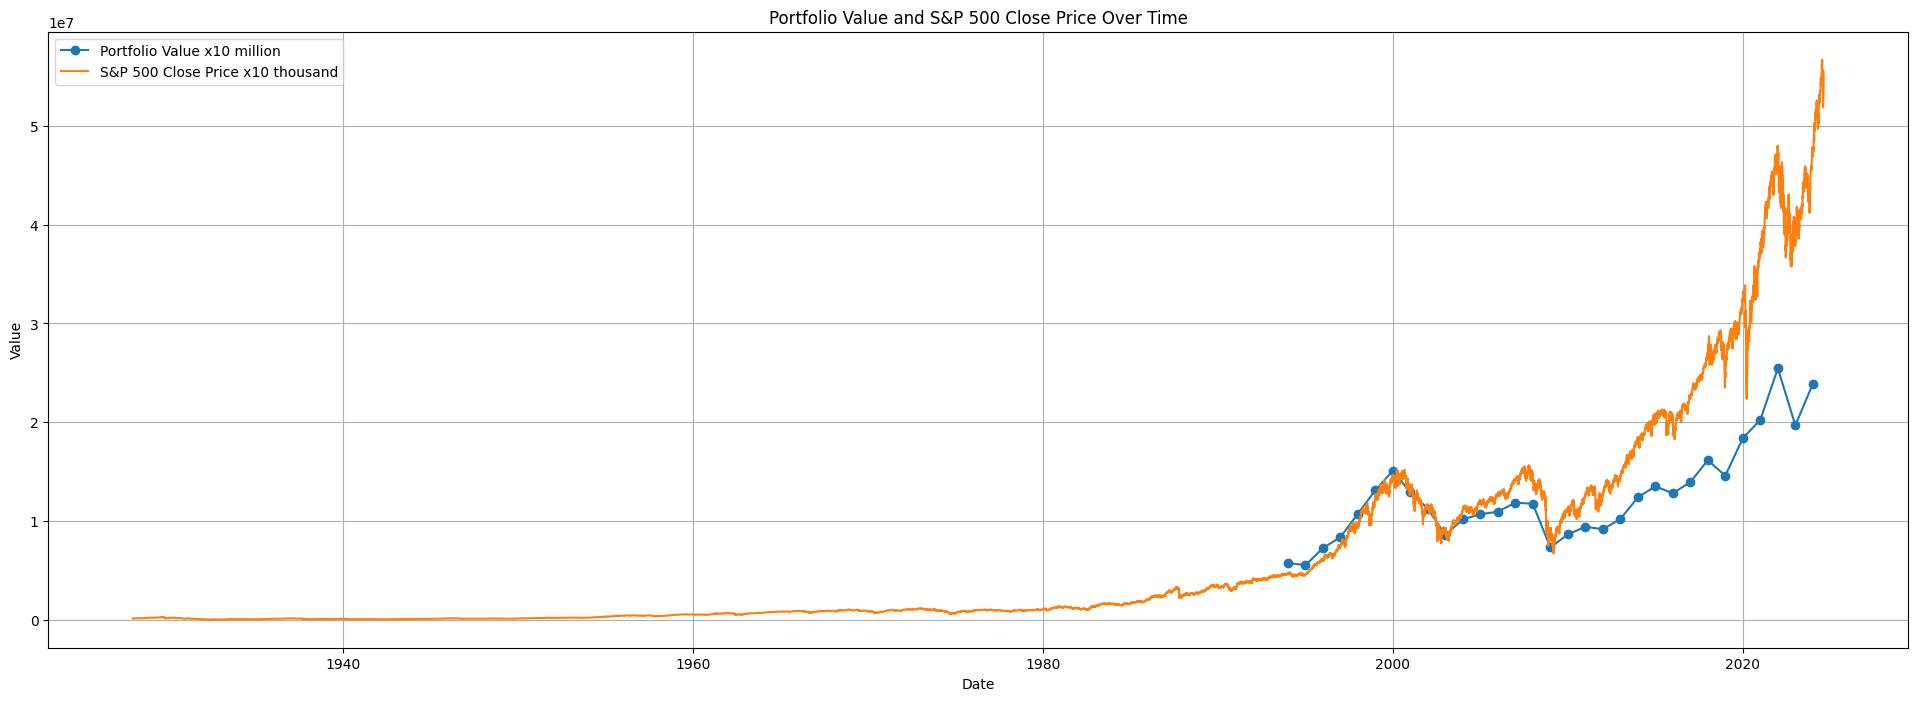

In [4]:
# Change these values to test the model

 ## currently dividends are not modeled in the function

dates, values, distributions = liquidate_portfolio(invested = 1000000, value = 7000000, tax_rate = 0.2, year = 1994, years = 30, ticker = '^SPX')

print("asset value")
print(f"min value: {sorted(values)[2:5]}")

plt.figure(figsize=(24, 8))
plt.plot(dates, values, marker='o', linestyle='-', label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value x10 million')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("yearly distributions")

plt.figure(figsize=(24, 8))
plt.bar(dates[:-1], distributions, color='blue', edgecolor='black', linewidth=10)  
plt.xlabel('Year')
plt.ylabel('Distribution Amount ($)')
plt.title('Yearly Distributions')
plt.grid(True)
plt.xticks(dates[:-1], rotation=45)

plt.show()


print("sp500 and sell dates")

plt.figure(figsize=(24, 6))
plt.plot(sp500.index, sp500['Close'], label='S&P 500 Close Price')
label_added = False
for date in dates:
    if not label_added:
        plt.axvline(x=date, color='r', linestyle='--', label='Portfolio Liquidation Date')
        label_added = True
    else:
        plt.axvline(x=date, color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('S&P 500 Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


print("overlayed")

plt.figure(figsize=(24, 8))

# Plot portfolio values
plt.plot(dates, values, marker='o', linestyle='-', label='Portfolio Value x10 million')

# Plot S&P 500 close prices
plt.plot(sp500.index, sp500['Close']* 1e4, label='S&P 500 Close Price x10 thousand')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio Value and S&P 500 Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()